# Homework 4 - Applied ML

## Exercise 2

The second exercise of this homework relates to unsupervised learning.

We will aggregate the referee information grouping by player, and use a clustering method such as K-means to cluster the soccer players in 2 disjoint clusters and see if a natural clustering tends to separate the players by skin colour. 

We will then remove features iteratively, and at each step perform again the clustering and compute the accuracy (considering that the clusters are separating the players by skin colour) and the silhouette score.

### Data cleaning

The first steps of the cleaning are very similar to exercise 1.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sns

In [2]:
# Import the data
df = pd.read_csv('CrowdstormingDataJuly1st.csv')

In [3]:
df = df.dropna(subset=['rater1', 'rater2'])

In [4]:
df['skin_colour'] = df[['rater1', 'rater2']].mean(axis=1)
df = df.drop(['rater1', 'rater2'], axis=1)
df.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skin_colour
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000


In [5]:
df.position = df[['position']].fillna('No Info')
df = df.dropna(subset=['height', 'weight'])

### Data aggregation and last cleaning

Now, we want to aggregate the referee information by player, and apply a clustering method on the data to try extracting a relevant pattern.

For the clustering algorithm, we chose to use the K-mean, as it fits the slide saw in course for choosing an appropriate tool for clusterization.

In [6]:
# Note: The link given in the description of the homework was quite useful for this step

# We add a refCount row
df['refCount'] = 0

# Add a column which tracks how many games each ref is involved in
refs=pd.unique(df['refNum'].values.ravel()) #list all unique ref IDs

#for each ref, count their dyads
for r in refs:
    df['refCount'][df['refNum'] == r] = len(df[df['refNum'] == r])

/home/bbaga/src/anaconda2/envs/py34/lib/python3.4/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
df.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skin_colour,refCount
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375,1
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750,1
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,29
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,29
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000,29


One thing that has been pointed out in an another analysis (given by the teacher), and that makes sense, is the fact that referees are present if they have one single dyad with a player, which is not interesting in our case. We want only the referee that performed at least one game, so the refCount must be at least 22 (2 teams of 11 players)!

In [8]:
allRefs = df.refNum.value_counts()

# keep only the ref with 22 dyads at least (filter)
goodRefs = allRefs[allRefs>=22]

In [9]:
# Apply the filter created above
df=df[df['refNum'].isin(goodRefs.index.values)]

In [10]:
df.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skin_colour,refCount
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,29
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,29
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000,29
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.250,29
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000,29


In [11]:
df_ref = df[['refCountry', 'yellowCards', 'yellowReds', 'redCards', 'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp', 'skin_colour', 'refCount']]

In [12]:
df = [] # not useful anymore

In [13]:
df_ref.head(50)

,refCountry,yellowCards,yellowReds,redCards,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skin_colour,refCount
5,4,0,0,0,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,29
6,4,0,0,0,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,29
7,4,0,0,0,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000,29
8,4,0,0,0,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.250,29
9,4,0,0,0,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000,29
10,4,1,0,0,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000,29
11,4,0,0,0,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.500,29
12,4,0,0,0,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000,29
13,4,0,0,0,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000,29
14,4,0,0,0,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,29


In [14]:
df_ref.isnull().sum()

refCountry       0
yellowCards      0
yellowReds       0
redCards         0
meanIAT        110
nIAT           110
seIAT          110
meanExp        110
nExp           110
seExp          110
skin_colour      0
refCount         0
dtype: int64

In [15]:
# remove the NaN rows
df_ref = df_ref.dropna(subset=['meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp'])

# And discard the skin_colour at last (we keep it for comparison purpose)
skin_col = df_ref['skin_colour'].copy()
del df_ref['skin_colour']

In [16]:
# Finally we scale the data
X = preprocessing.scale(df_ref)

### Clustering

Our choice of our unsupervised learning algorithm for clustering is K-Means. After applying a clusterisation on the whole cleaned dataset, we will iteratively remove some features and see how it evolves.

In [17]:
clust = KMeans(n_clusters=2, random_state=0).fit(X) # the default kmeans++ is used

In [18]:
clust

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=0, tol=0.0001,
    verbose=0)

In [19]:
clust.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [20]:
# we create a function to compare the labels with the skin colors of the player to predict 'accuracy'
# This comparison first put all color to 0 if < 0.5 and to 1 if > 0.5
# return a result between 0.5 and 1, from random to perfect match.

def compareSkinColor(skinColor, clust_labels):
    skinColor = (skinColor > 0.5) # to get the binary separation of skin color
    (skinColor & clust_labels).mean()
    np.not_equal(skinColor, clust_labels)
    score = (np.not_equal(skinColor, clust_labels)).mean()
    # as we have 2 clusters randomly labeled, we take the max between both comparison (inversing labels)
    alt_score = 1 - score # inversing labels is the same as inversing all boolean tests above
    return max(score, alt_score)

In [21]:
compareSkinColor(skin_col, clust.labels_)

0.52727972917301047

We will now try and remove iteratively each feature and see if some interesting things happen !
Two functions are first created to help us: 

- 'removeSingleFeatures' aims at iteratively remove one feature and return all the results (scores and silhouette-scores) at once.
- 'ApproxSilhouetteScore' has been created because we were running short of memory while performing the normal silhouette score. The idea was to calculate the silhouette score on parts of the data many times and to average the results, thus giving a reasonable approximation of the overall result.

In [22]:
# This method apply a k-mean iteratively removing each feature
# it returns the scores and the silhouettes results for each
def removeSingleFeature(df):
    idx = list(df.columns.values)
    scores = []
    silhouettes = []
    for c in idx:
        xFor = preprocessing.scale(df.drop(c, axis = 1)) # scale the data
        clusterFor = KMeans(n_clusters=2, random_state=0).fit(xFor) # apply the clustering method
        
        score = compareSkinColor(skin_col, clusterFor.labels_)
        silhouette = ApproxSilhouetteScore(xFor, clusterFor.labels_, 5000, 7)
        
        scores.append(score)
        silhouettes.append(silhouette)   
    return idx, scores, silhouettes

In [23]:
# Because we run short of memory when using silhouette_score, we run silhouette score on N randomly chosen samples K times
# and average the result.
def ApproxSilhouetteScore(X, labels, N, K, metric='euclidean'):
    sils = []
    for k in range(K):
        sils.append(silhouette_score(X, labels, metric=metric, sample_size=N))
    score = np.average(sils)
    return score

Let's calculate the silhouette-score on the whole dataset and see how the 2 clusters separate the data.

In [24]:
#silhouetteSc = silhouette_score(X, clust.labels_, metric='euclidean', sample_size=2000) # too slow
silhouetteSc = ApproxSilhouetteScore(X, clust.labels_, 800, 20, metric='euclidean',)

In [25]:
silhouetteSc

0.2236944410740532

So for the whole dataset, only ~53% of accuracy and a silhouette-score of ~0.22 is reached, thus showing no relation between those clusters and the skin colours.

Let's now remove each feature iteratively and compare the results !

In [26]:
idx, scores, silhouettes = removeSingleFeature(df_ref)

In [27]:
scores

[0.83928603413996306,
 0.83967113865553744,
 0.83928603413996306,
 0.52727972917301047,
 0.83928603413996306,
 0.68473374052911562,
 0.83928603413996306,
 0.83928603413996306,
 0.68473374052911562,
 0.83928603413996306,
 0.84228626699385623]

In [28]:
silhouettes

[0.87315772759483201,
 0.80260271168895814,
 0.86594609224125529,
 0.23381541480259821,
 0.86812353569183942,
 0.25684167261967933,
 0.86194527397206178,
 0.87078133264297108,
 0.25490554701417906,
 0.86150438276982411,
 0.86835153199124215]

In [29]:
idx

['refCountry',
 'yellowCards',
 'yellowReds',
 'redCards',
 'meanIAT',
 'nIAT',
 'seIAT',
 'meanExp',
 'nExp',
 'seExp',
 'refCount']

Let's plot the results for each iteration so we get a better viz !

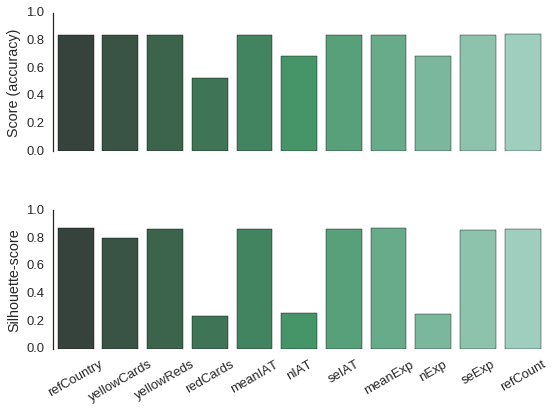

In [31]:
sns.set(style="white", context="talk")

# Set up the matplotlib figure
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot the score
sns.barplot(idx, scores, palette="BuGn_d", ax=ax1)
ax1.set_ylabel("Score (accuracy)")

# Plot the silhouette-score
sns.barplot(idx, silhouettes, palette="BuGn_d", ax=ax2)
ax2.set_ylabel("Silhouette-score")
ax2.set_xticklabels(labels=idx, rotation=30)
ax2.set_axes

# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, yticks=np.arange(0, 1.01, 0.2))
plt.tight_layout(h_pad=3)

### Conclusion

As show in the graph above, it seems that many results omitting one feature can yield reasonably good clustering. That said, those results should be taken with a grain of salt, as the data is very skewed: a large majority of players is said to be white in our dataset ! As it has been stated , by using a scoring such as f1-measure, taking into account the skewness of the dataset, low results were obtained, thus suggesting that no evidence of behaviour changement regarding to the skin colour seems to be drawn. Additionnal studies could dig into similar approaches by separating countries beforehand, but that is another story...